In [1]:
import numpy as np
import pandas as pd
import gget
import glob
import networkx as nx
import os
import seaborn as sns
import gget
from textwrap import fill
import scanpy as sc
import anndata as an
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import zscore
import scipy
from scipy.sparse import csr_matrix 

# locals
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3  

# Load sc data

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.X = adata.layers['raw_counts'].copy()
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

sc.pp.normalize_total(
        adata, 
        target_sum=1e6,
        key_added='norm_factor',
)

adata.layers["cpm"] = adata.X.copy()

adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2', 'norm_factor'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts', 'cpm'
    obsp: 'connectivi

# Load isoforms

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/isoforms/isoform_data.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df = df[df['cell_id'].isin(adata.obs_names)] # filter out undetected CBs

# add nulti-map flag
df['n_isoforms'] = df.groupby('gene_name')['transcript_name'].transform('nunique')

# drop genes that don't express multiple isoforms
df = df[df['n_isoforms'] > 1]
df['value'] = 1
print(f"{df.shape=}")
df.head()

df.shape=(47827803, 8)
df.shape=(41870261, 10)


,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name,n_isoforms,value
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204,5,1
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204,5,1
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204,5,1
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202,5,1
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202,5,1


In [4]:
def drop_cols_below_threshold(df, threshold):
    """
    Drops columns from a DataFrame where the column sum is less than a threshold.

    Args:
        df: The pandas DataFrame.
        threshold: The threshold value for the column sum.

    Returns:
        The modified DataFrame with columns dropped.
    """
    # Calculate column sums
    col_sums = df.sum(axis=0)  # Sum along rows (axis=0)

    # Identify columns to drop
    cols_to_drop = col_sums[col_sums < threshold].index

    # Drop columns
    df.drop(cols_to_drop, axis=1, inplace=True)  # Drop along columns (axis=1)

    return df


# create a cell x transcript matrix
X_iso = pd.pivot_table(
    df, 
    index='cell_id',
    columns='transcript_name',
    values='value',
    # aggfunc='sum',
    fill_value=0.0,
)

print(f"{X_iso.shape=}")
threshold = 10

X_iso = drop_cols_below_threshold(X_iso, threshold)
print(f"{X_iso.shape=}")

X_iso.shape=(8563, 81229)
X_iso.shape=(8563, 37697)


# make isoform adata

In [5]:
def df_to_anndata(df):
    """
    Converts a pandas DataFrame to an AnnData object.

    Args:
        df: The pandas DataFrame to convert.

    Returns:
        An AnnData object.
    """

    adata = an.AnnData(csr_matrix(df.values))
    adata.obs_names = df.index
    adata.var_names = df.columns

    return adata


def merge_obs(adata1, adata2):
    """
    Merges .obs from two AnnData objects based on obs_names (assumed to be the index).
    Returns a new AnnData object with the merged .obs.

    Args:
        adata1: The first AnnData object.
        adata2: The second AnnData object. .obs from this object will be merged into the new object.

    Returns:
        A new AnnData object with the merged .obs.
    """

    # Convert .obs to DataFrames
    obs1 = adata1.obs
    obs2 = adata2.obs

    # Merge DataFrames on 'obs_names' (assuming it's the index in both)
    merged_obs = pd.merge(
        obs1, 
        obs2, 
        left_index=True, 
        right_index=True, 
        how="left",
    )

    # Create a copy of adata1 to avoid modifying the original
    adata_merged = adata1.copy()

    # Assign merged .obs to the new AnnData object
    adata_merged.obs = merged_obs

    return adata_merged


pdf = df_to_anndata(X_iso)
pdf = merge_obs(pdf, adata)

# add gene-level annotations
pdf.var['split'] = pdf.var.index.str.split("-")
pdf.var['gene_name'] = pdf.var['split'].apply(lambda x: x[0])                         

pdf

AnnData object with n_obs × n_vars = 8563 × 37697
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2', 'norm_factor'
    var: 'split', 'gene_name'

# DEG

In [6]:
sc.tl.rank_genes_groups(
    pdf, 
    groupby="cluster_str",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='hsc_deg',
)

deg = sc.get.rank_genes_groups_df(
    pdf, 
    group=None,
    key='hsc_deg',
)

deg.head()

ranking genes


... storing 'gene_name' as categorical


    finished: added to `.uns['hsc_deg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:52)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,C1,CLU-204,28.419352,0.953066,1.166120e-177,1.098980e-173,0.965877,0.610009
1,C1,CLU-215,26.920017,0.932318,1.280593e-159,8.045753e-156,0.919277,0.582183
2,C1,MGP-203,26.699635,0.883596,4.753042e-157,2.559649e-153,0.968933,0.634599
3,C1,MGP-204,25.684097,0.926085,1.759842e-145,8.292595e-142,0.868857,0.547239
4,C1,CLU-203,25.086123,1.165907,7.048783e-139,2.657180e-135,0.666157,0.352028


In [7]:
pvals_adj = 0.05
logfoldchanges = 0.0
n_gene = 10
sig = deg.copy()
sig = sig[sig['logfoldchanges'] >=  logfoldchanges]


# get the genes that have different isoforms in differnet groups
sig['gene_name'] = sig['names'].apply(lambda x: x.split("-")[0])
sig['gene_groups'] = sig.groupby('gene_name')['group'].transform('nunique')
sig = sig[sig['gene_groups'] > 1]

sig = sig[sig['pvals_adj'] <= pvals_adj]


sig = sig.sort_values(
    by=['group', 'logfoldchanges'], 
    ascending=[True, False],
)

sig = sig.groupby('group').head(n_gene)
sig



,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,gene_name,gene_groups
368,C1,FLNB-218,3.794665,1.694322,1.478432e-04,6.949183e-03,0.069519,0.022002,FLNB,4
306,C1,FLNB-227,4.202576,1.623134,2.638948e-05,1.487002e-03,0.078941,0.026316,FLNB,4
459,C1,FLNB-203,3.236024,1.450229,1.212073e-03,4.528397e-02,0.064680,0.024159,FLNB,4
166,C1,ALKAL2-204,6.019630,1.344445,1.748157e-09,1.845946e-07,0.127578,0.052200,ALKAL2,3
38,C1,AHNAK2-203,11.959097,1.235122,5.819110e-33,2.642928e-30,0.276802,0.127049,AHNAK2,3
17,C1,TSC22D1-201,15.276210,1.221323,1.101638e-52,8.835844e-50,0.363636,0.172347,TSC22D1,5
133,C1,FLNB-215,6.615579,1.176790,3.701010e-11,4.729389e-09,0.153807,0.070966,FLNB,4
4,C1,CLU-203,25.086123,1.165907,7.048783e-139,2.657180e-135,0.666157,0.352028,CLU,4
360,C1,GSN-203,3.838433,1.162852,1.238219e-04,5.901027e-03,0.088617,0.040552,GSN,5
328,C1,SERPINB6-212,4.069541,1.124643,4.710575e-05,2.483560e-03,0.096257,0.045298,SERPINB6,6


In [8]:
def filter_and_display_deg(deg, group, pvals_adj=0.05, logfoldchanges=0.0, n_gene=25):
    """
    Filters and displays differentially expressed genes (DEGs) based on specified criteria.

    Args:
      deg (pd.DataFrame): DataFrame containing DEG information.
      group (str): The group to filter DEGs by.
      pvals_adj (float, optional): Adjusted p-value threshold. Defaults to 0.05.
      logfoldchanges (float, optional): Log fold change threshold. Defaults to 0.0.
      n_gene (int, optional): Number of top DEGs to display. Defaults to 25.

    Returns:
      pd.DataFrame: Filtered and formatted DataFrame containing the top DEGs.
    """
    sig = deg.copy()
    sig = sig[sig['pvals_adj'] <= pvals_adj]
    sig = sig[sig['logfoldchanges'] >= logfoldchanges]

    # Extract gene names from 'names' column
    sig['gene_name'] = sig['names'].apply(lambda x: x.split("-")[0])
    sig = sig[sig['group'] == group]

    return sig[['gene_name', 'names', 'logfoldchanges', 'pct_nz_group', 'pct_nz_reference']].head(n_gene)


group = 'C2'
pvals_adj = 0.05
logfoldchanges = 0.0
n_gene = 25

sig = filter_and_display_deg(deg, group, pvals_adj, logfoldchanges, n_gene)
sig

,gene_name,names,logfoldchanges,pct_nz_group,pct_nz_reference
37697,TNFRSF11B,TNFRSF11B-201,4.645529,0.932648,0.059756
37698,LUM,LUM-203,4.025631,0.966324,0.095287
37699,THBS1,THBS1-201,3.385583,0.916667,0.134195
37700,LUM,LUM-201,4.912729,0.775685,0.038174
37701,DCN,DCN-220,4.270883,0.788813,0.060344
37702,TNC,TNC-201,4.126513,0.780251,0.065482
37703,IFI6,IFI6-203,4.171879,0.758562,0.061078
37704,IFI6,IFI6-202,2.178268,0.976598,0.311702
37705,IGFBP5,IGFBP5-201,4.175250,0.720890,0.056820
37706,DCN,DCN-204,4.361289,0.638699,0.042578


In [9]:
def perform_enrichment_analysis(sig, database='ontology', n_genes=50):
    """
    Performs enrichment analysis on a set of query genes using gget.enrichr.

    Args:
        sig (pd.DataFrame): DataFrame containing gene information, including a 'gene_name' column.
        database (str, optional): The database to use for enrichment analysis. Defaults to 'ontology'.
        n_genes (int, optional): The maximum number of genes to consider for the analysis. Defaults to 50.

    Returns:
        pd.DataFrame: A DataFrame containing the top 10 enriched pathways with their adjusted p-values and overlapping genes.
    """
    query_genes = sig['gene_name'].unique()
    n = min(len(query_genes), n_genes)
    query_genes = query_genes[:n]

    edf = gget.enrichr(query_genes, database=database)

    pd.set_option('display.max_colwidth', 150)
    return edf[['path_name', 'p_val', 'adj_p_val', 'overlapping_genes']].head(10)

n_genes = 50
database = 'ontology'

perform_enrichment_analysis(sig, database, n_genes)

Wed Aug 21 10:14:33 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,p_val,adj_p_val,overlapping_genes
0,negative regulation of signal transduction (GO:0009968),0.000007,0.003154,"[IGFBP5, APOD, THBS1, DKK1, DCN]"
1,regulation of endothelial cell apoptotic process (GO:2000351),0.000013,0.003154,"[SEMA5A, CCL2, THBS1]"
2,regulation of smooth muscle cell proliferation (GO:0048660),0.000018,0.003154,"[IGFBP5, APOD, THBS1]"
3,regulation of cell migration (GO:0030334),0.000054,0.005294,"[SEMA5A, PDGFRA, IFITM1, IGFBP5, THBS1]"
4,regulation of mitochondrial depolarization (GO:0051900),0.000057,0.005294,"[IFI6, DCN]"
5,extracellular structure organization (GO:0043062),0.000069,0.005294,"[LUM, TNC, THBS1, DCN]"
6,external encapsulating structure organization (GO:0045229),0.000070,0.005294,"[LUM, TNC, THBS1, DCN]"
7,regulation of endothelial cell chemotaxis (GO:2001026),0.000109,0.005778,"[SEMA5A, THBS1]"
8,negative regulation of cell-substrate junction organization (GO:0150118),0.000125,0.005778,"[APOD, THBS1]"
9,negative regulation of focal adhesion assembly (GO:0051895),0.000125,0.005778,"[APOD, THBS1]"


# All clusters GSEA

In [10]:
def plot_pathway_enrichment(df):
    """
    Plots pathway enrichment results from a DataFrame.

    Args:
        df: DataFrame containing 'path_name' and 'p_val' columns.
    """
    
    # Sort and calculate -log10(p_val)
    df_sorted = df.sort_values('p_val')
    df_sorted['neg_log10_pval'] = -np.log10(df_sorted['p_val'])
    df_sorted['pname'] = df_sorted['path_name'].apply(lambda x: x.split("(")[0].capitalize())
    
    wrapped_labels = [fill(label, 50) for label in df_sorted['pname']]

    # Create the plot
    plt.barh(
        wrapped_labels, 
        df_sorted['neg_log10_pval'], 
        color='seagreen',
        height=0.5,
        ec='k',
    )

    # Set labels and title
    plt.xlabel('-log10(p-value)', fontsize=12)

    # Invert y-axis and set x-axis ticks/limits
    plt.gca().invert_yaxis() 
    sns.despine()

    # Show the plot
    plt.tight_layout()

Wed Aug 21 10:14:34 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


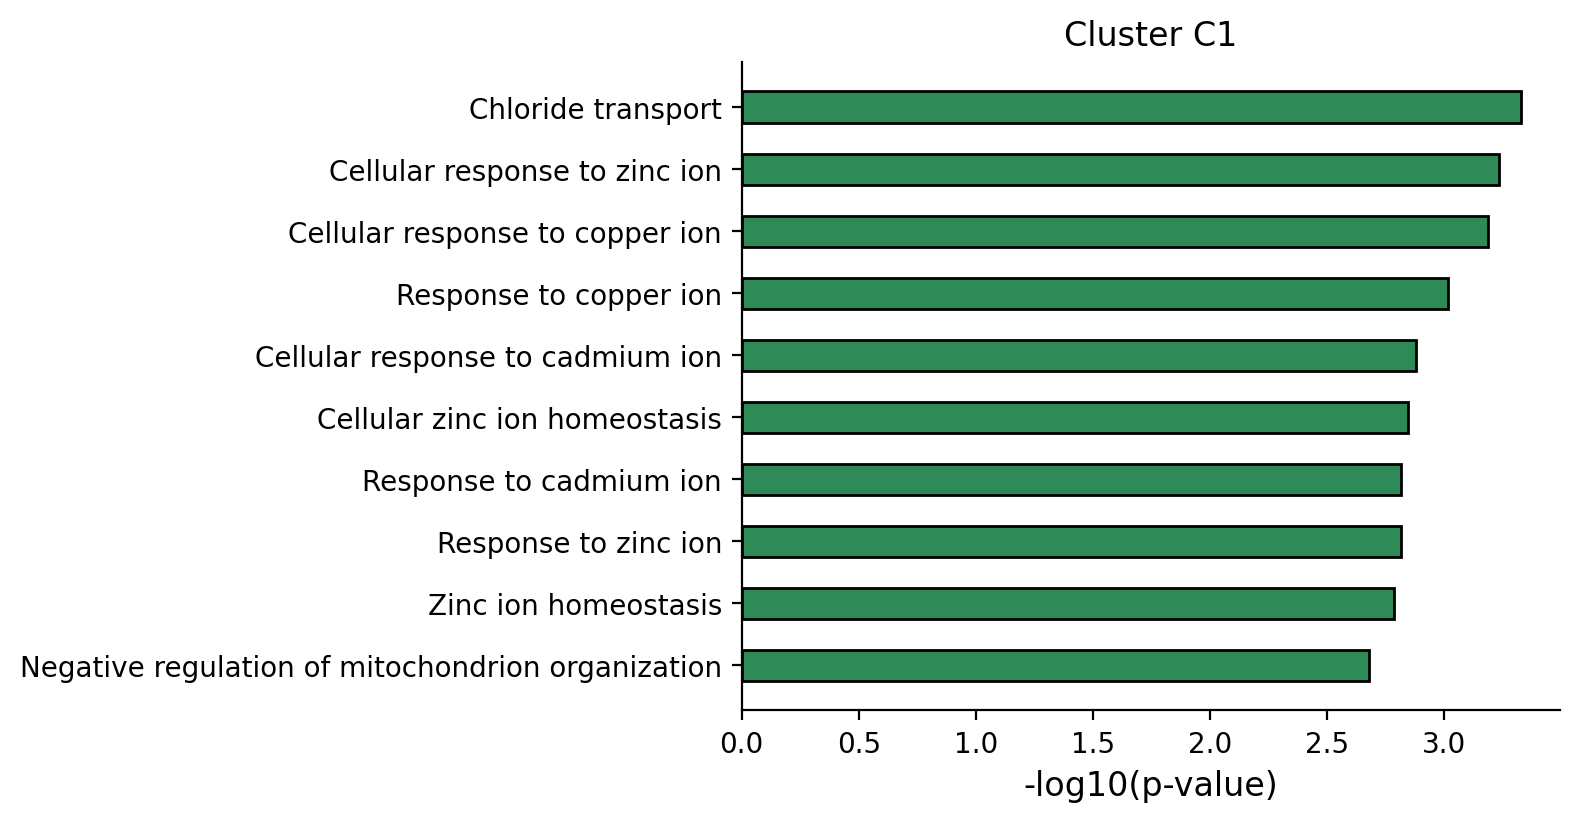

Wed Aug 21 10:14:35 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


C1 sig.shape=(50, 5)


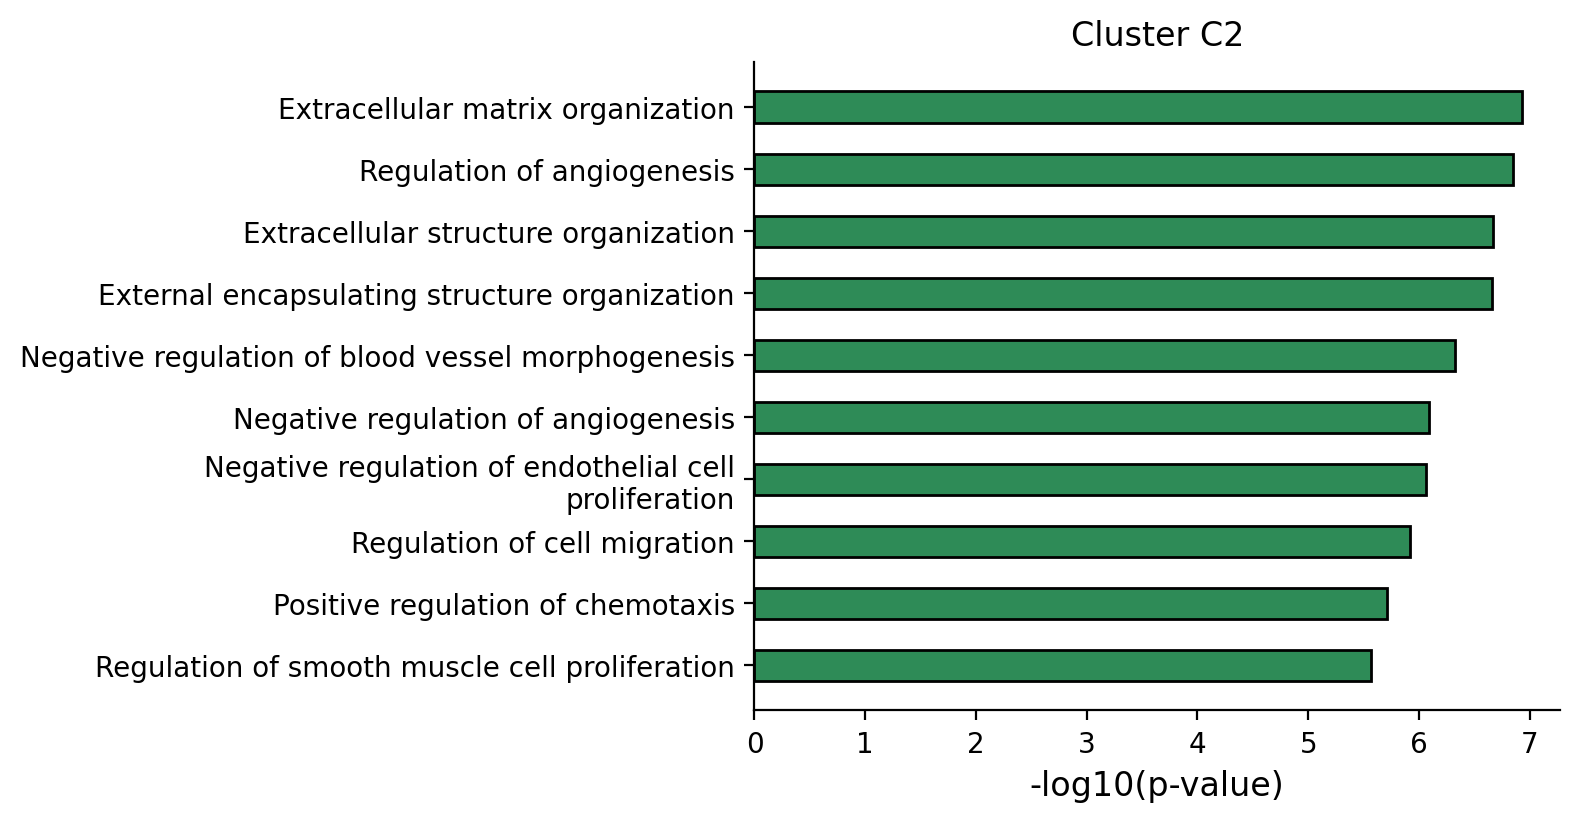

Wed Aug 21 10:14:36 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


C2 sig.shape=(50, 5)


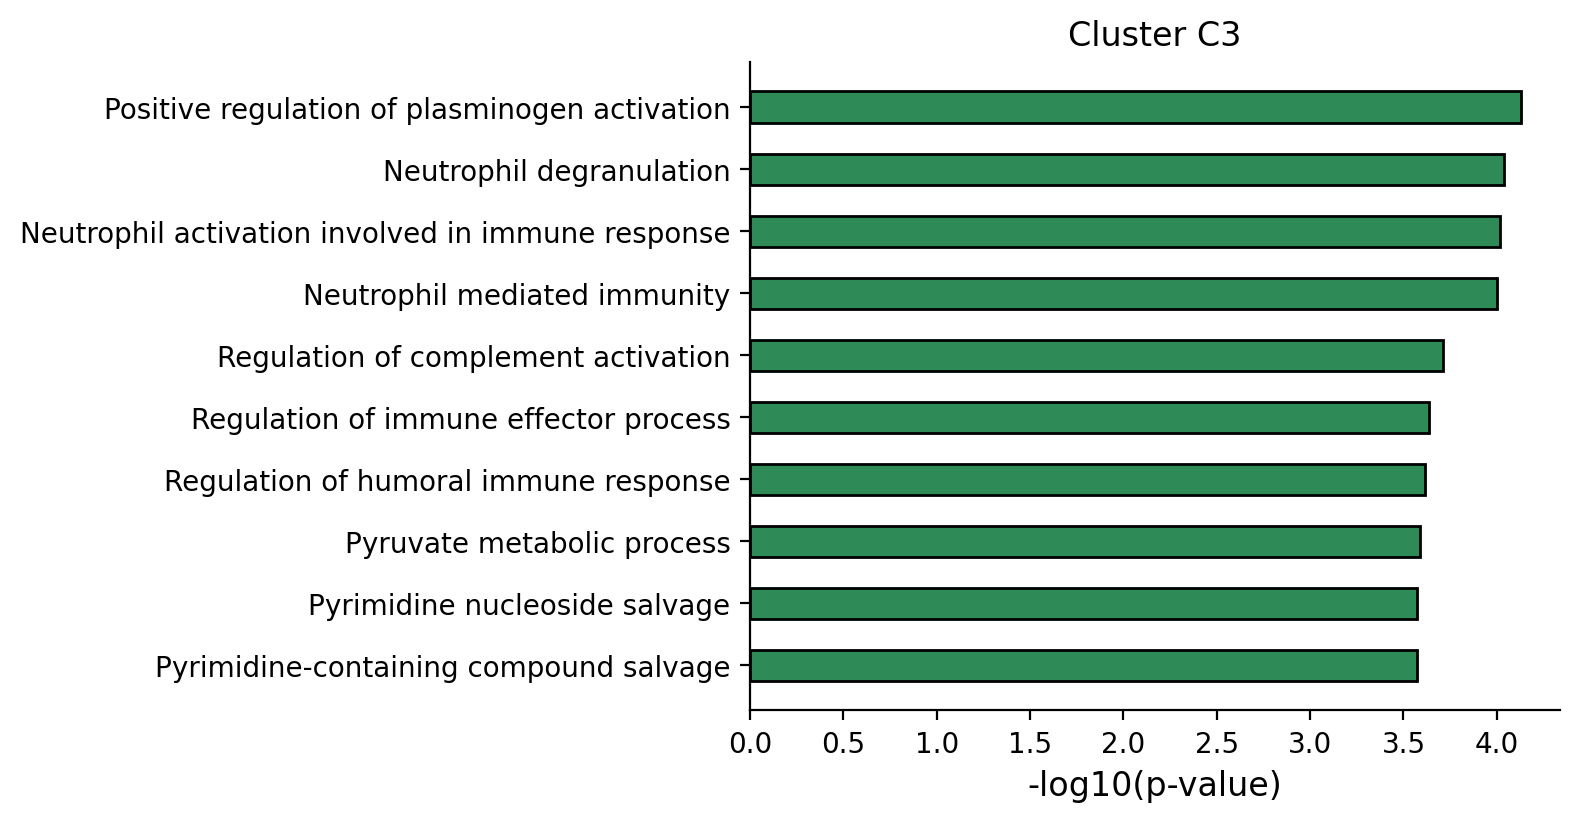

Wed Aug 21 10:14:36 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


C3 sig.shape=(50, 5)


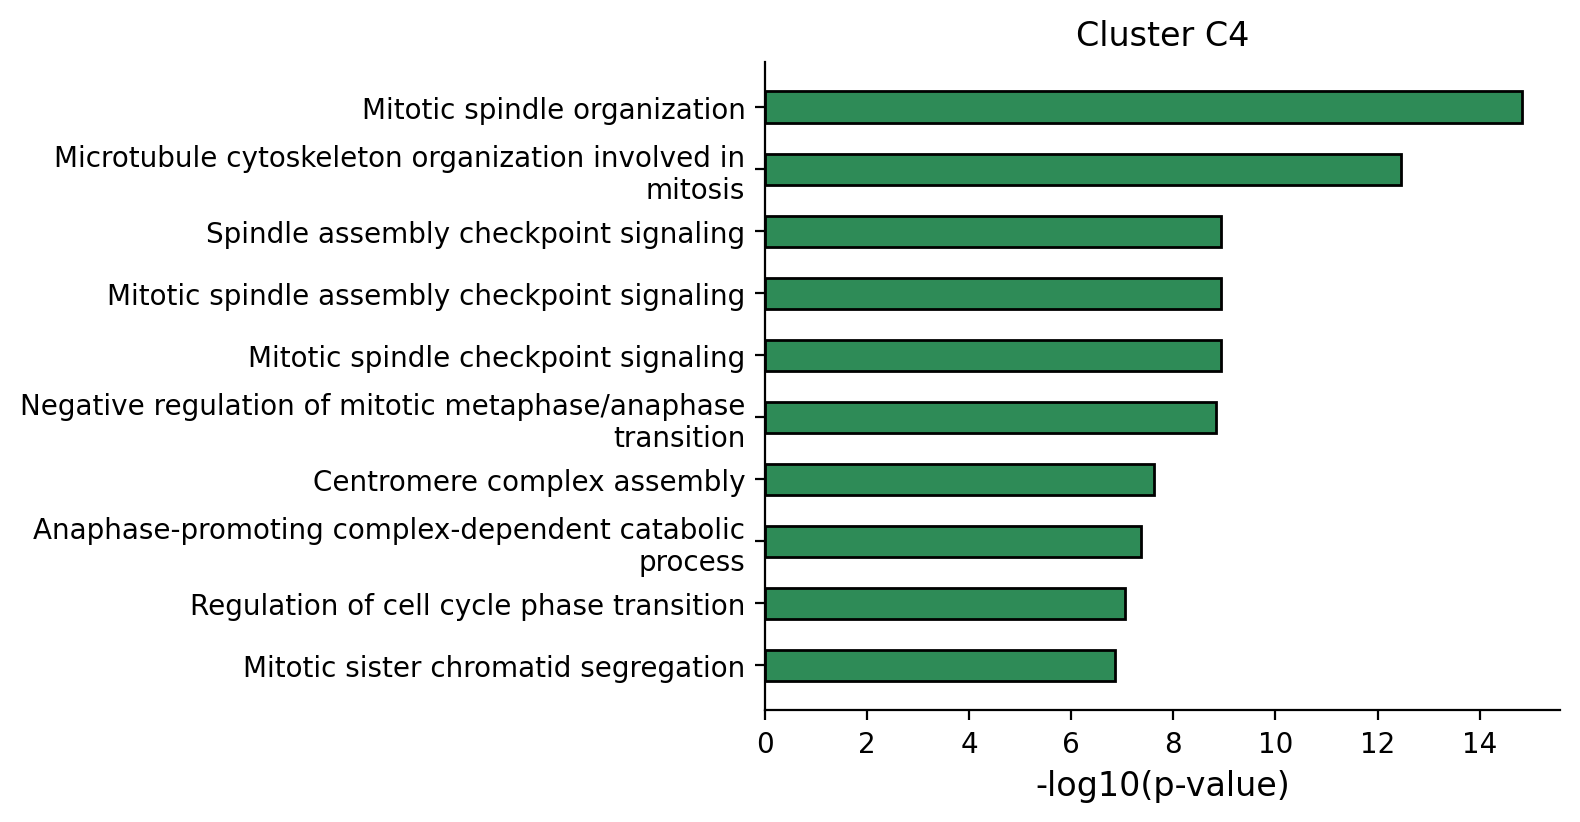

Wed Aug 21 10:14:37 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


C4 sig.shape=(50, 5)


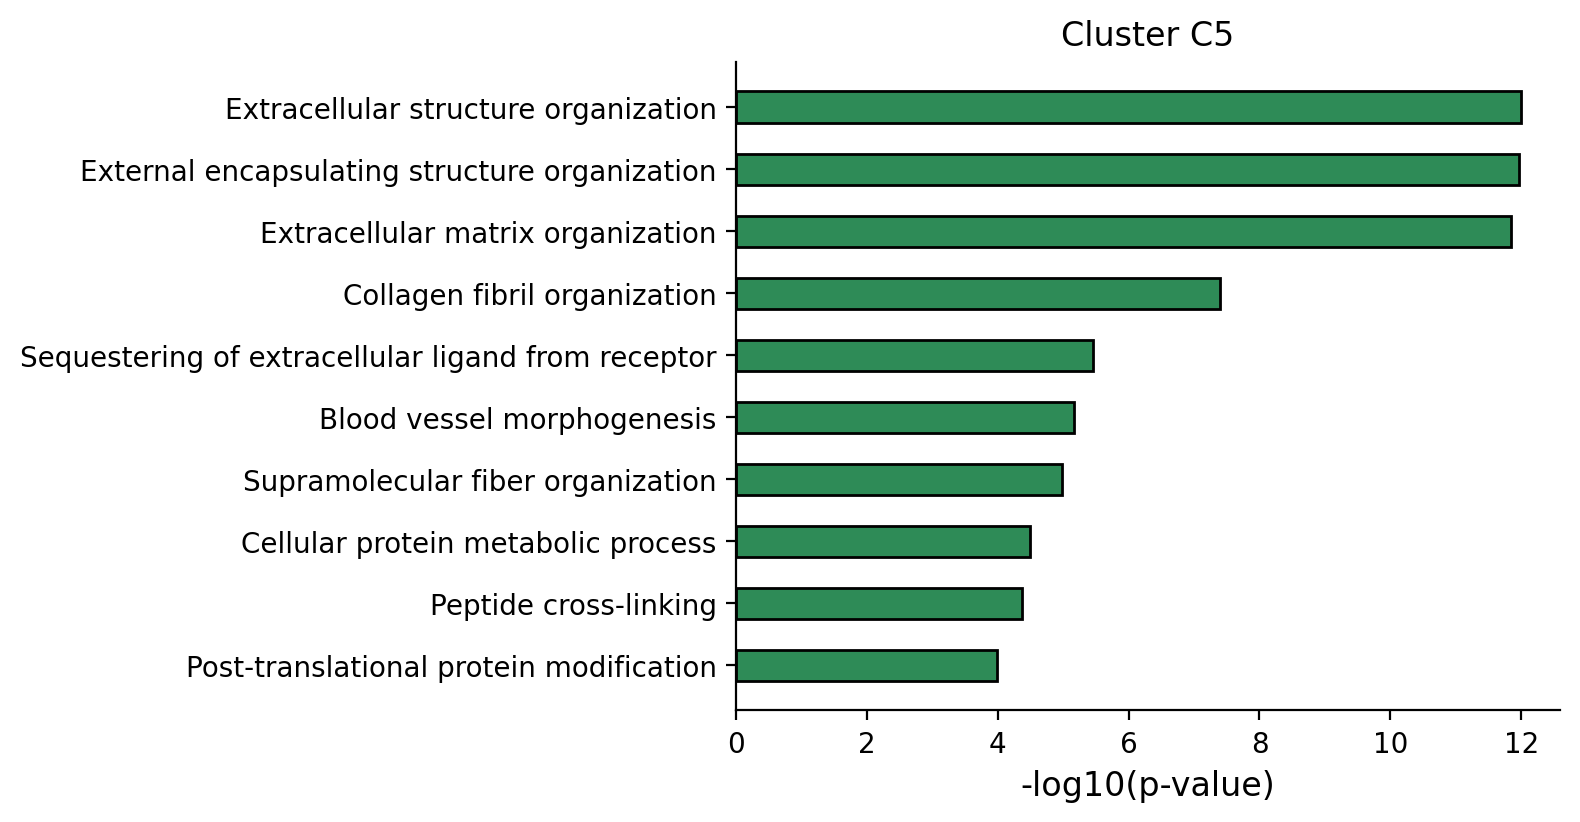

C5 sig.shape=(50, 5)


In [11]:
pvals_adj = 0.05
logfoldchanges = 0.0
n_gene = 50
gsea_genes = 50
database = 'ontology'

for group in deg['group'].unique():
    sig = filter_and_display_deg(
        deg, 
        group, 
        pvals_adj, 
        logfoldchanges, 
        n_gene,
    )
    if not len(sig) > 0:
        continue
        
    edf = perform_enrichment_analysis(
        sig, 
        database, 
        gsea_genes,
    )
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 8, 4
    plot_pathway_enrichment(edf.head(10))
    plt.title(f"Cluster {group}")
    plt.show()
    
    print(f"{group} {sig.shape=}")

# Isoform plotting

In [12]:
def plot_iso_single(adata, query, size=20):
    """
    Plots UMAP visualization of single-cell data, highlighting isoforms specified in 'query'.

    Args:
        adata: AnnData object containing the single-cell data.
        query: String or list of strings representing the isoform(s) to highlight.
        size: Size of the scatterplot points (default: 20).
    """

    if not isinstance(query, list):
        query = [query]

    for q in query:
        # Create the base plot with all cells in light grey
        sns.scatterplot(
            data=adata.obs,
            x='UMAP 1',
            y='UMAP 2',
            ec='none',
            color='lightgrey',
            s=size,
        )

        # Highlight the cells expressing the query isoform
        mask = adata[:, q].X.todense() == 1
        sns.scatterplot(
            data=adata.obs[mask],
            x='UMAP 1',
            y='UMAP 2',
            ec='none',
            color='r',
            alpha=0.75,
            s=size / 2.5,
        )

        # Format the plot
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('UMAP 2')
        plt.xlabel('UMAP 1')
        sns.despine()
        plt.title(q)  # Use the specific query for the title
        plt.gca().set_aspect('auto')

        # Show the plot for this query
        plt.show()

In [13]:
group = 'C4'
pvals_adj = 0.01
logfoldchanges = 1.0
n_gene = 15

sig = filter_and_display_deg(
    deg, 
    group, 
    pvals_adj, 
    logfoldchanges, 
    n_gene,
)
sig

,gene_name,names,logfoldchanges,pct_nz_group,pct_nz_reference
113091,UBE2C,UBE2C-204,5.290768,0.897010,0.036428
113092,TOP2A,TOP2A-201,4.458617,0.925249,0.066951
113093,CKS1B,CKS1B-201,3.016322,0.940199,0.176360
113094,PTTG1,PTTG1-201,3.013291,0.901993,0.166688
113095,TYMS,TYMS-201,3.681738,0.779070,0.087929
113096,CENPF,CENPF-201,5.084314,0.714286,0.030273
113097,GTSE1,GTSE1-201,5.915467,0.674419,0.015827
113098,TK1,TK1-201,3.818734,0.710963,0.070845
113099,TOP2A,TOP2A-202,5.021115,0.664452,0.028640
113100,HMGB2,HMGB2-203,4.091549,0.687708,0.056400


In [14]:
hsc_genes = adata.uns['go_annotations']['gene_name'].unique()

pvals_adj = 0.05
logfoldchanges = 0.0

sig = deg.copy()
sig['gene_name'] = sig['names'].apply(lambda x: x.split("-")[0])
sig = sig[sig['gene_name'].isin(hsc_genes)]
sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] >= logfoldchanges]
print(f"{sig.shape=}")

sig

sig.shape=(8, 9)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,gene_name
37747,C2,FSTL1-201,16.546030,1.223789,1.710142e-61,6.382895e-59,0.502283,0.246366,FSTL1
37825,C2,CCN3-201,9.294198,5.747549,1.483201e-20,1.350537e-18,0.146689,0.002936,CCN3
75428,C3,OCIAD2-205,8.752768,0.837725,2.081840e-18,1.509214e-15,0.342506,0.205835,OCIAD2
75465,C3,OCIAD2-204,7.710216,0.780424,1.256054e-14,4.877140e-12,0.316745,0.196353,OCIAD2
113544,C4,XRCC5-206,6.760869,1.191000,1.371667e-11,1.128990e-09,0.315615,0.150609,XRCC5
114231,C4,OCIAD2-205,4.222440,0.620062,2.416722e-05,7.874087e-04,0.328904,0.225851,OCIAD2
114613,C4,FSTL1-201,3.526220,0.437437,4.215361e-04,1.025865e-02,0.378738,0.292677,FSTL1
150837,C5,FSTL1-201,10.557470,1.261372,4.691330e-26,3.336775e-23,0.579418,0.283268,FSTL1


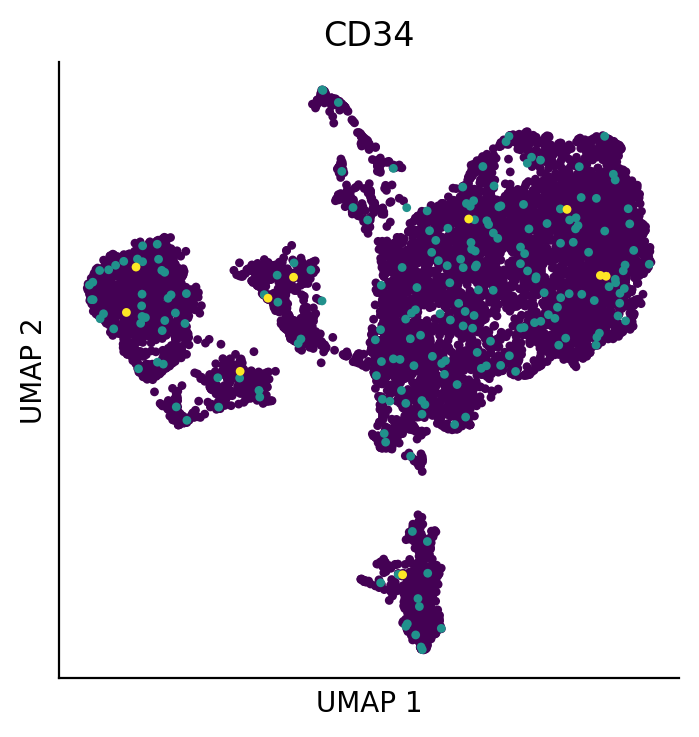

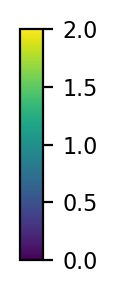

In [15]:
def plot_umap_expression(adata, query):
    """
    Plots a UMAP scatterplot with expression of a given gene colored.

    Args:
        adata: AnnData object containing UMAP coordinates and gene expression data.
        query: String specifying the gene name to plot expression for.
    """

    # Get expression values for the query gene
    trx_idx = adata.var[adata.var['gene_name'] == query].index
    expression = adata[:, trx_idx].to_df().sum(axis=1).values

    # Sort expression values for color mapping
    order = np.argsort(expression)

    # Create the plot
    fig, ax = plt.subplots()

    # Plot the UMAP scatterplot with colormap
    scatter = ax.scatter(
        adata.obs['UMAP 1'],
        adata.obs['UMAP 2'],
        c=expression[order],
        cmap='viridis',
        s=10,
        ec='none',
    )

    # Set labels and appearance
    ax.set(xlabel="UMAP 1", ylabel="UMAP 2", xticks=[], yticks=[])
    ax.set_aspect('auto')
    ax.set_title(query)
    sns.despine()
    
    plt2.create_standalone_colorbar(scatter)


    
query = 'CD34'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_umap_expression(pdf, query)

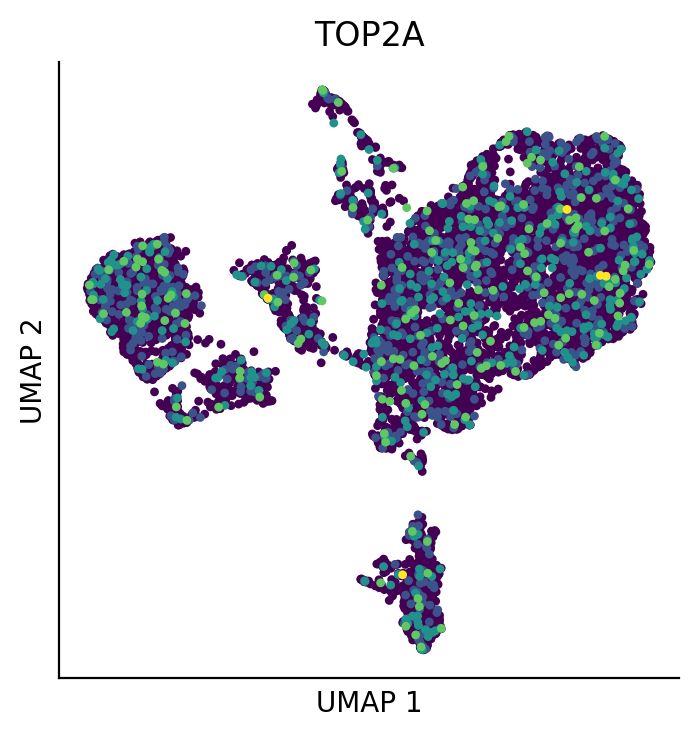

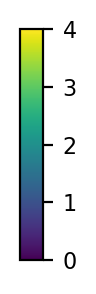

['TOP2A-201', 'TOP2A-202', 'TOP2A-203', 'TOP2A-204', 'TOP2A-205']


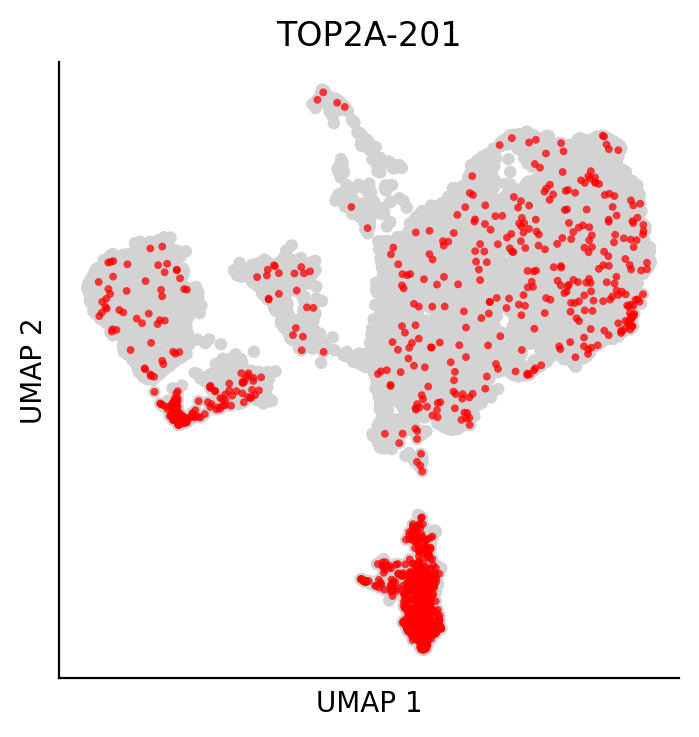

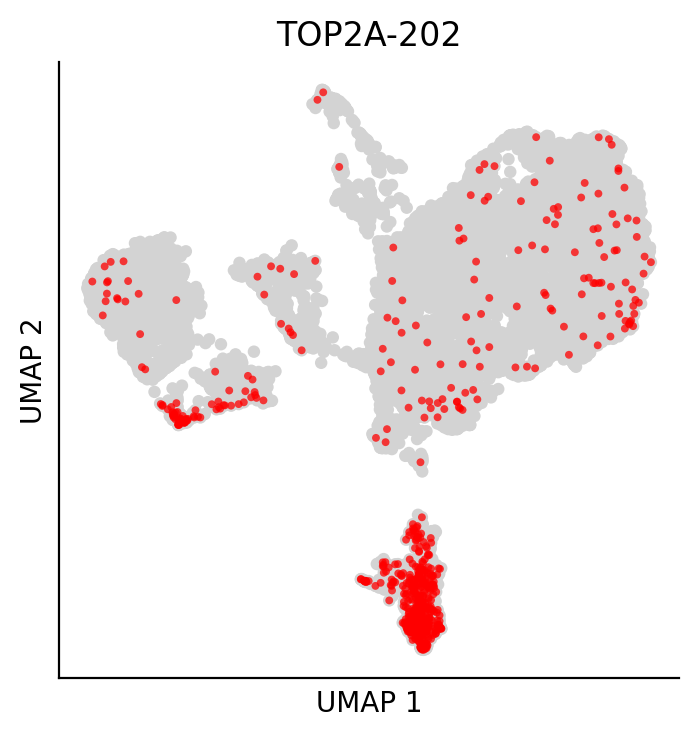

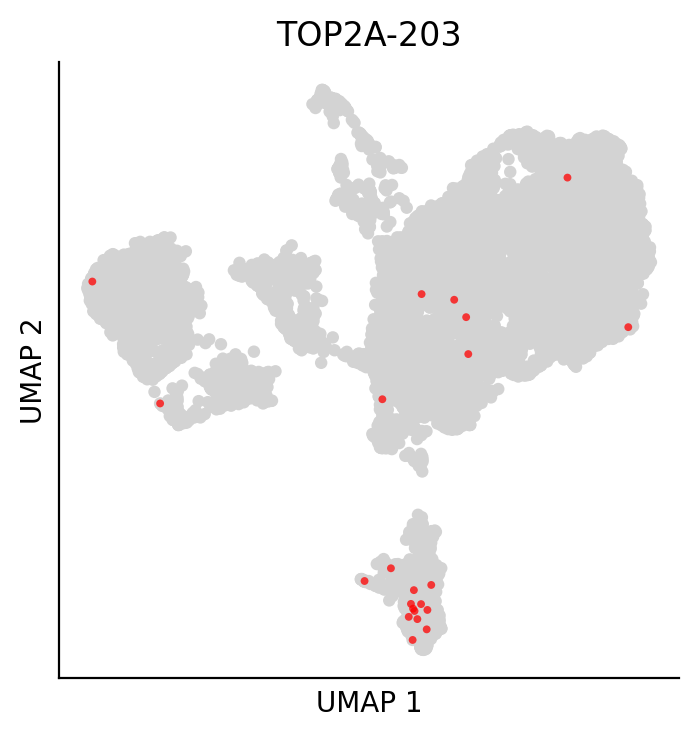

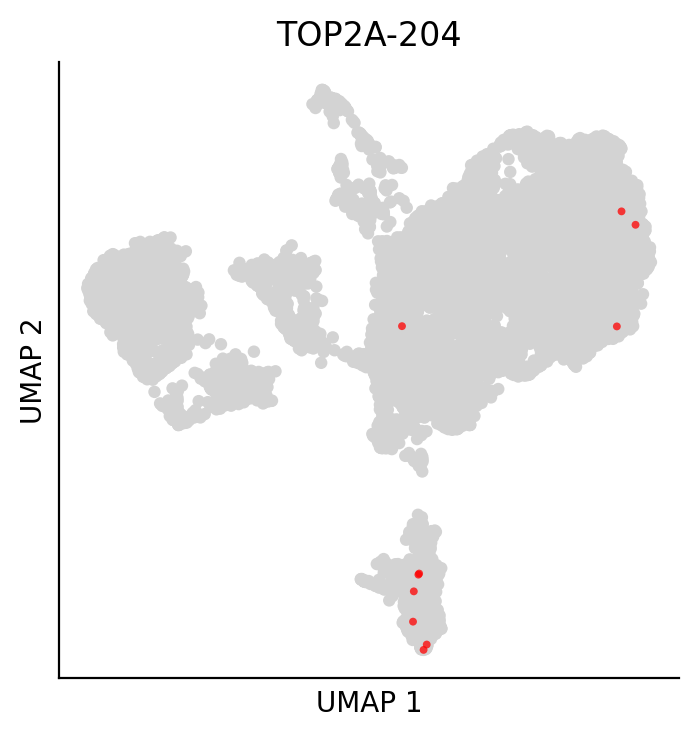

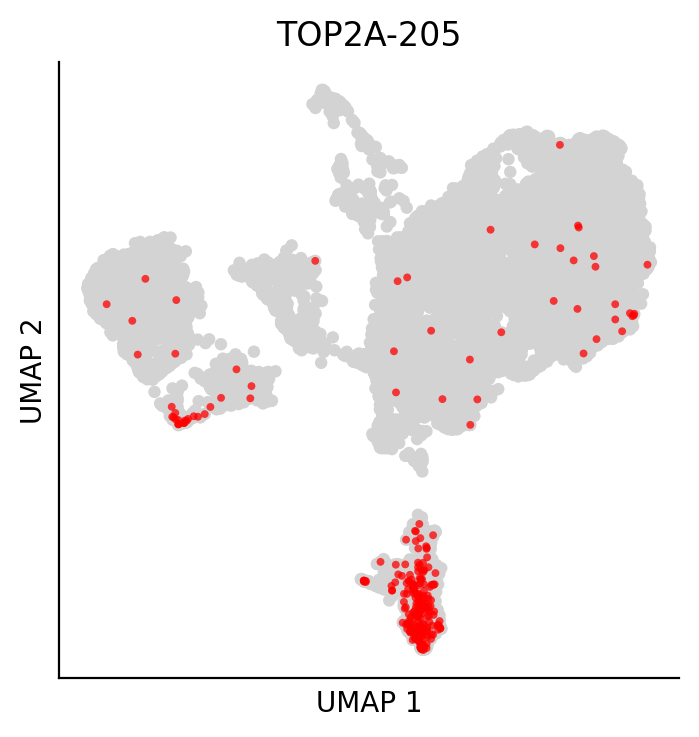

In [16]:
gene = 'TOP2A'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

plot_umap_expression(pdf, gene)
plt.show()

query = list(pdf.var[pdf.var['gene_name'] == gene].index)
print(query)
plot_iso_single(pdf, query)

# Pivot

In [17]:
plot = deg.copy()
plot['gene_name'] = plot['names'].apply(lambda x: x.split("-")[0])

plot = pd.pivot_table(
    plot,
    index=['gene_name', 'names'],
    columns='group',
    values='pct_nz_group'
)

plot = plot.drop(columns='C6')

print(f"{plot.shape=}")

plot.head(15)

plot.shape=(37697, 5)


group                       C1        C2        C3        C4        C5
gene_name names                                                       
A1BG      A1BG-203    0.006875  0.003425  0.001171  0.003322  0.008949
          A1BG-204    0.485867  0.394406  0.567330  0.493355  0.700224
A2M       A2M-201     0.003565  0.059932  0.006440  0.004983  0.017897
          A2M-207     0.000255  0.008562  0.001171  0.000000  0.000000
A4GALT    A4GALT-202  0.004838  0.001142  0.002927  0.008306  0.000000
          A4GALT-206  0.010695  0.005137  0.015222  0.011628  0.000000
          A4GALT-207  0.107461  0.032534  0.141101  0.071429  0.033557
AAAS      AAAS-201    0.002801  0.003425  0.004098  0.006645  0.000000
          AAAS-202    0.001273  0.000571  0.002342  0.003322  0.002237
          AAAS-208    0.001528  0.002283  0.001171  0.003322  0.000000
          AAAS-213    0.001019  0.000571  0.002342  0.004983  0.002237
          AAAS-220    0.001783  0.001712  0.000585  0.004983  0.004474
AACS      AACS-201    0.014515  0.009132  0.010539  0.018272  0.015660
          AACS-205    0.003056  0.002854  0.002927  0.004983  0.004474
          AACS-206    0.020372  0.007991  0.016393  0.023256  0.008949

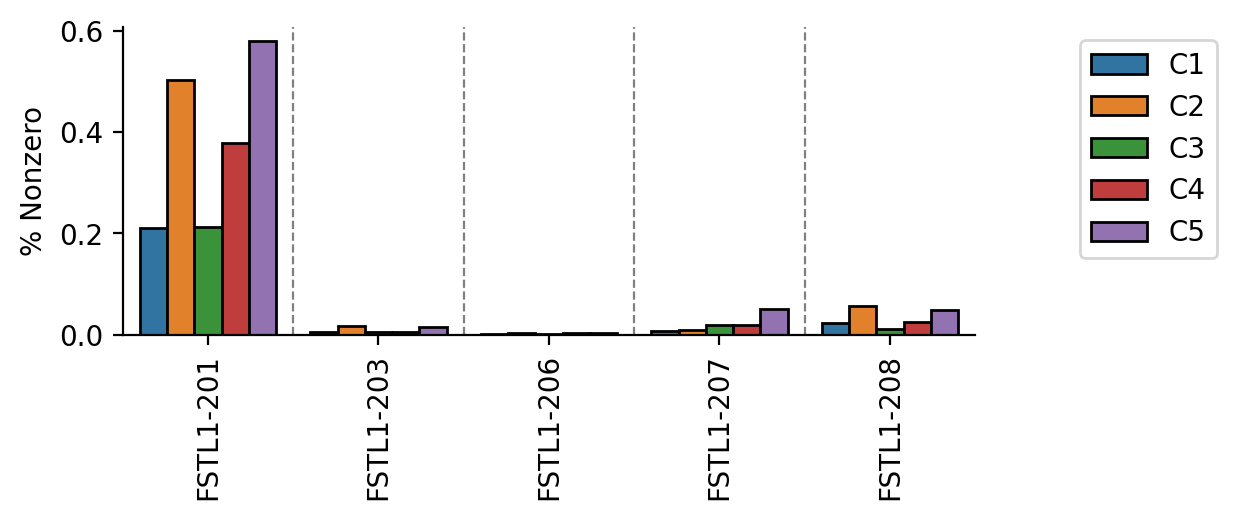

In [18]:
def plot_pivot(plot, query):
    
    plot = plot.reset_index()
    plot = plot[plot['gene_name'] == query]
    plot = pd.melt(plot, 
                   id_vars=['gene_name', 'names'])
    
    n_iso = plot['names'].nunique()
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = (1.1 * n_iso), 2

    sns.barplot(
        data=plot,
        x='names',
        y='value',
        hue='group',
        palette='tab10',
        ec='k'
    )

    plt.xlabel("")
    plt.ylabel("% Nonzero")
    plt.gca().tick_params(axis='x', rotation=90)

    # Get the positions of the x ticks
    xticks = np.array(plt.gca().get_xticks())

    # Calculate the positions for the vertical lines (midway between the ticks)
    vlines_positions = (xticks[:-1] + xticks[1:]) / 2

    # Add vertical dashed lines
    for vline_pos in vlines_positions:
        plt.axvline(
            x=vline_pos, 
            color='gray', 
            linestyle='--', 
            linewidth=0.8,
        ) 

    sns.move_legend(
        plt.gca(),
        title="",
        loc='upper right',
        bbox_to_anchor=(1.3, 1),
    )

    # plt.ylim([0,1])

    sns.despine()
    
    
query = 'FSTL1'
plot_pivot(plot, query)

In [19]:
pang = adata.uns['panglaodb']
pang = pang[pang['cell_type'] == 'Hematopoietic stem cells']
pang_genes = list(pang['gene_name'].unique())
pang.head()

,gene_name,cell_type,ubiquitousness_index,gene_type,organ,sensitivity_human,specificity_human,ensembl_id
740,THY1,Hematopoietic stem cells,0.095,protein-coding gene,Bone,0.0,0.032268,ENSG00000154096
741,MPL,Hematopoietic stem cells,0.001,protein-coding gene,Bone,0.0,0.000000,ENSG00000117400
742,KIT,Hematopoietic stem cells,0.015,protein-coding gene,Bone,0.0,0.002506,ENSG00000157404
743,PROM1,Hematopoietic stem cells,0.021,protein-coding gene,Bone,0.0,0.007206,ENSG00000007062
744,FLT3,Hematopoietic stem cells,0.009,protein-coding gene,Bone,0.0,0.000940,ENSG00000122025


In [20]:
rank_df = pd.concat([
    plot.idxmax(axis=1),
    plot.max(axis=1),],
    axis=1,
).reset_index()

rank_df.columns = [
    'gene_name', 
    'transcript_name',
    'max_cluster',
    'max_value',
]

rank_df = rank_df[rank_df['gene_name'].isin(pang_genes)]

rank_df['n_cluster'] = rank_df.groupby('gene_name')['max_cluster'].transform('nunique')
rank_df = rank_df[rank_df['n_cluster'] > 1]
rank_df = rank_df[rank_df['max_value'] < 1]
print(f"{rank_df.shape=}")
rank_df = rank_df.sort_values(by='max_value', ascending=False)
rank_df.head(35)

rank_df.shape=(109, 5)


,gene_name,transcript_name,max_cluster,max_value,n_cluster
18083,MGST1,MGST1-205,C4,0.973422,3
5082,CD59,CD59-201,C4,0.857143,4
5090,CD59,CD59-209,C4,0.700997,4
5092,CD59,CD59-211,C3,0.695550,4
5083,CD59,CD59-202,C4,0.593023,4
975,ALDH1A1,ALDH1A1-201,C2,0.559361,2
34391,TXNIP,TXNIP-204,C5,0.543624,2
32476,THY1,THY1-201,C5,0.447427,2
31656,TAF7,TAF7-201,C5,0.391499,2
32479,THY1,THY1-206,C5,0.281879,2


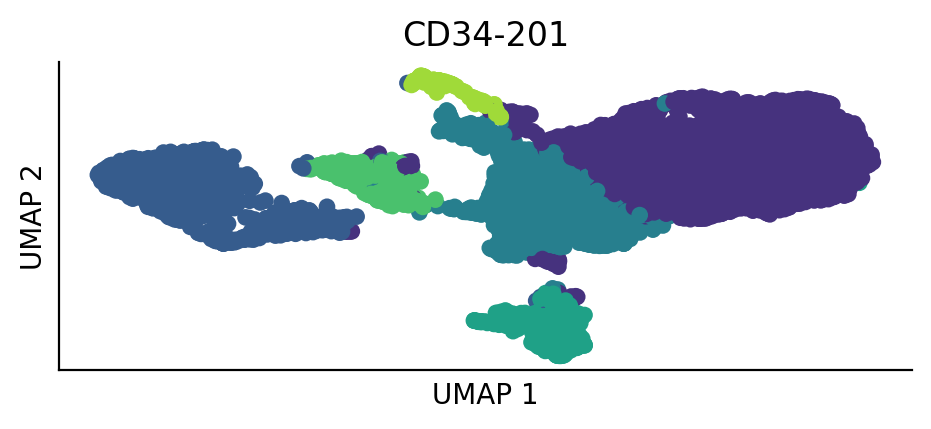

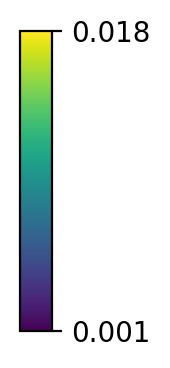

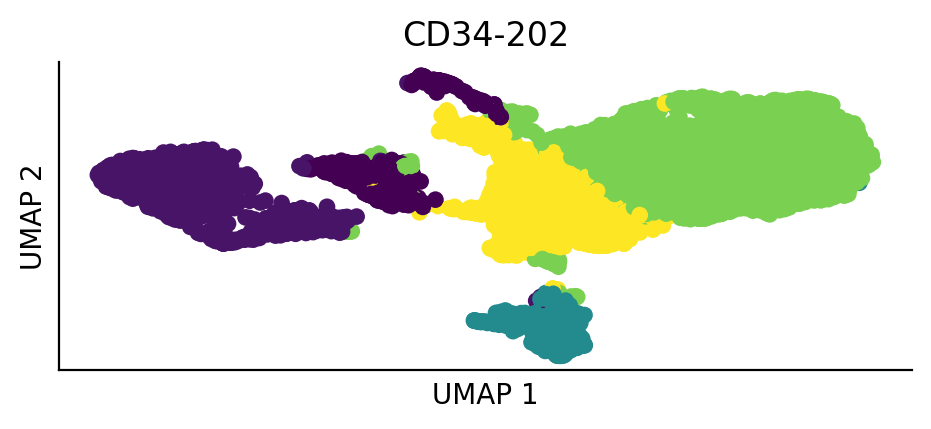

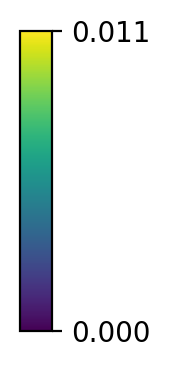

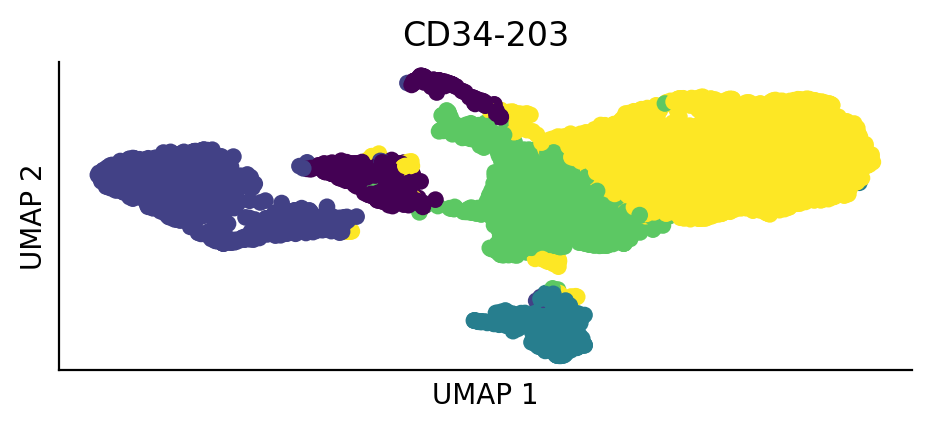

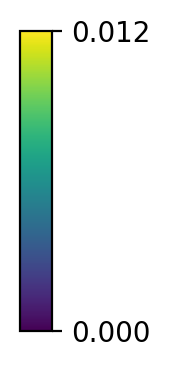

In [21]:
def plot_cluster_percents(adata, query):
    
    gene_mask = adata.var[adata.var['gene_name'] == query].index
    pts = adata.uns['hsc_deg']['pts']
    pts = pts.loc[gene_mask].T
    
    for transcript in pts.columns:
        pt_min = pts[transcript].min()
        pt_max = pts[transcript].max()
        percentage_map = pts[transcript].to_dict()
        plot = pdf.obs
        plot[transcript] = plot['cluster_str'].map(percentage_map)
        
        sns.scatterplot(
            data=plot, 
            x='UMAP 1',
            y='UMAP 2',
            hue=transcript,
            ec='none',
            vmin=0,
            vmax=1,
            palette='viridis',
            legend=False,
        )
        plt.title(transcript)
        plt.yticks([])
        plt.xticks([])
        sns.despine()
        plt.show()
        
        plt2.make_colorbar(tick_labels=[
            f"{pt_min:.3f}",
            f"{pt_max:.3f}",
        ])
        
        plt.show()

query = 'CD34'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_cluster_percents(pdf, query)

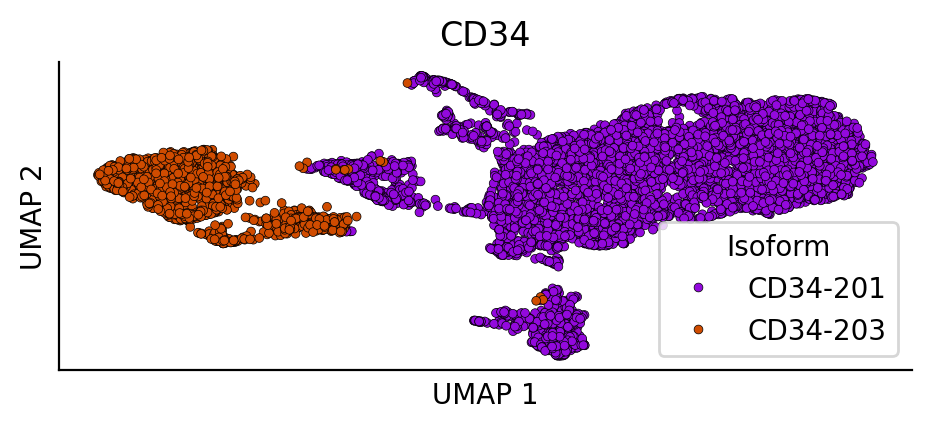

In [22]:
def plot_dominant_isoform(adata, query):    
    gene_mask = adata.var[adata.var['gene_name'] == query].index
    pts = adata.uns['hsc_deg']['pts']
    pts = pts.loc[gene_mask].T
    pts = pts.idxmax(axis=1)
    
    plot = pdf.obs.copy()
    plot['Isoform'] = plot['cluster_str'].map(pts.to_dict())
    
    plot = plot.sort_values(by='Isoform')
    
    sns.scatterplot(
            data=plot, 
            x='UMAP 1',
            y='UMAP 2',
            hue='Isoform',
            ec='k',
            palette='gnuplot',
            s=10,
        )

    plt.title(query)
    plt.yticks([])
    plt.xticks([])
    sns.despine()
    
query = 'CD34'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_dominant_isoform(pdf, query)

In [23]:
rank_df = pd.concat([
    plot.idxmax(axis=1),
    plot.max(axis=1),],
    axis=1,
).reset_index()

rank_df.columns = [
    'gene_name', 
    'transcript_name',
    'max_cluster',
    'max_value',
]

# rank_df = rank_df[rank_df['gene_name'].isin(pang_genes)]
rank_df = rank_df[rank_df['gene_name'].isin(hsc_genes)]

rank_df['n_cluster'] = rank_df.groupby('gene_name')['max_cluster'].transform('nunique')
rank_df = rank_df[rank_df['n_cluster'] > 1]
rank_df = rank_df[rank_df['max_value'] < 1]
print(f"{rank_df.shape=}")
rank_df = rank_df.sort_values(by='max_value', ascending=False)
rank_df.head(55)

rank_df.shape=(126, 5)


,gene_name,transcript_name,max_cluster,max_value,n_cluster
11795,FSTL1,FSTL1-201,C5,0.579418,2
21438,OCIAD2,OCIAD2-205,C3,0.342506,2
21437,OCIAD2,OCIAD2-204,C3,0.316745,2
36016,XRCC5,XRCC5-206,C4,0.315615,2
34859,UFL1,UFL1-201,C4,0.167774,2
28838,SH2B3,SH2B3-201,C4,0.142857,2
12133,GATA2,GATA2-213,C4,0.129568,4
2047,ARIH2,ARIH2-205,C4,0.127907,3
29981,SNAI2,SNAI2-201,C4,0.122924,3
34544,UBAP2L,UBAP2L-210,C4,0.117940,3


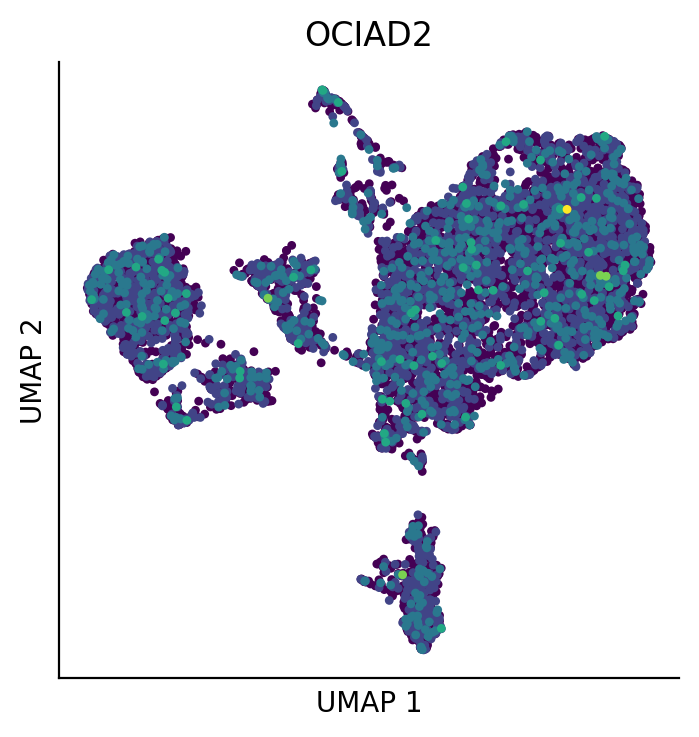

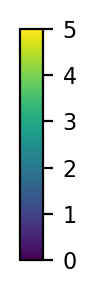

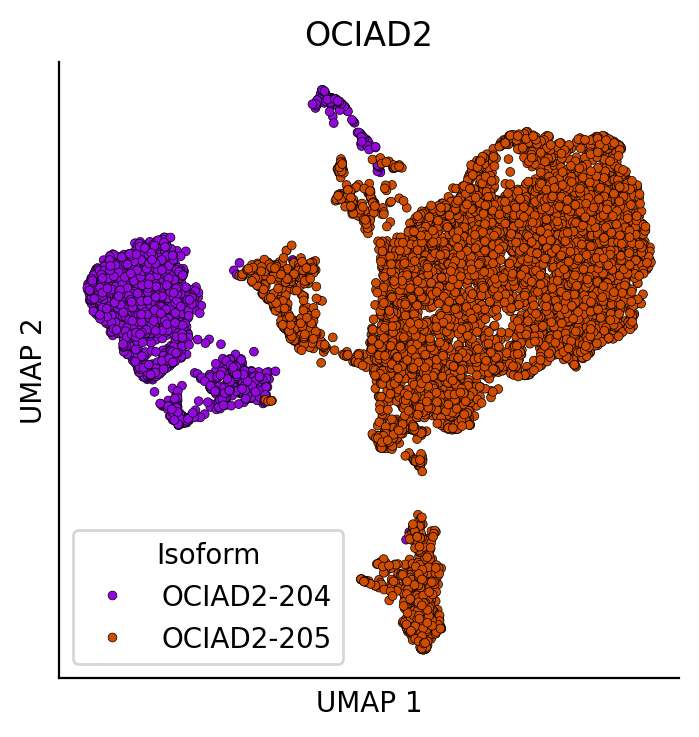

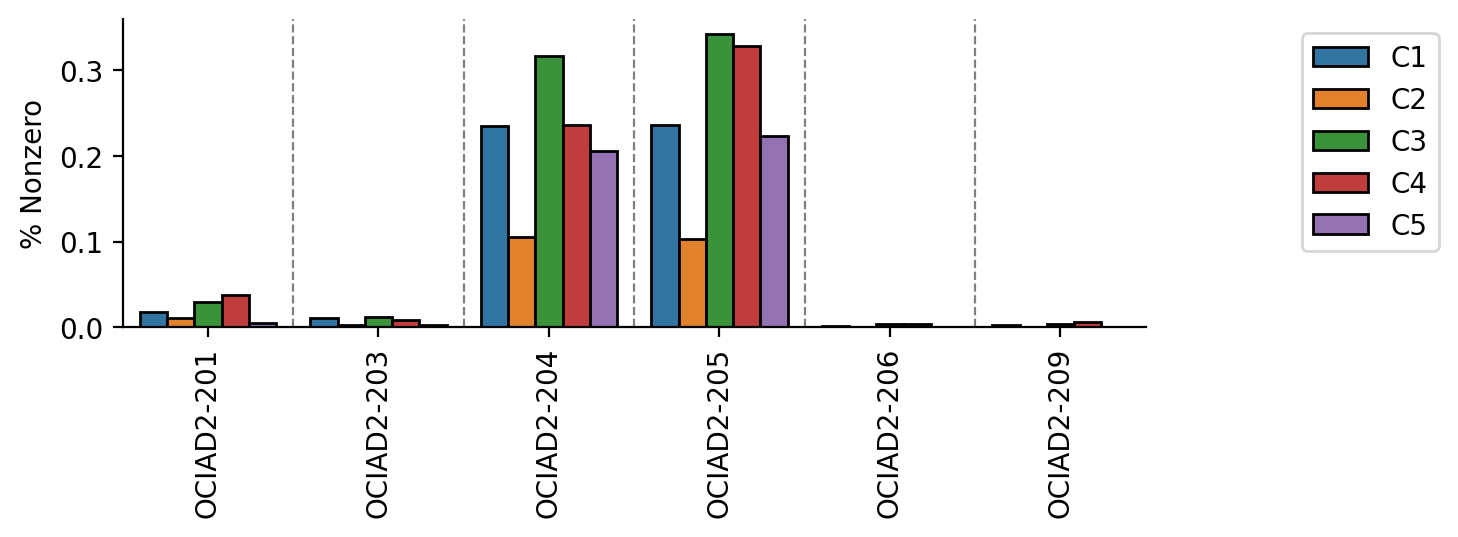

['OCIAD2-201', 'OCIAD2-203', 'OCIAD2-204', 'OCIAD2-205', 'OCIAD2-206', 'OCIAD2-209']


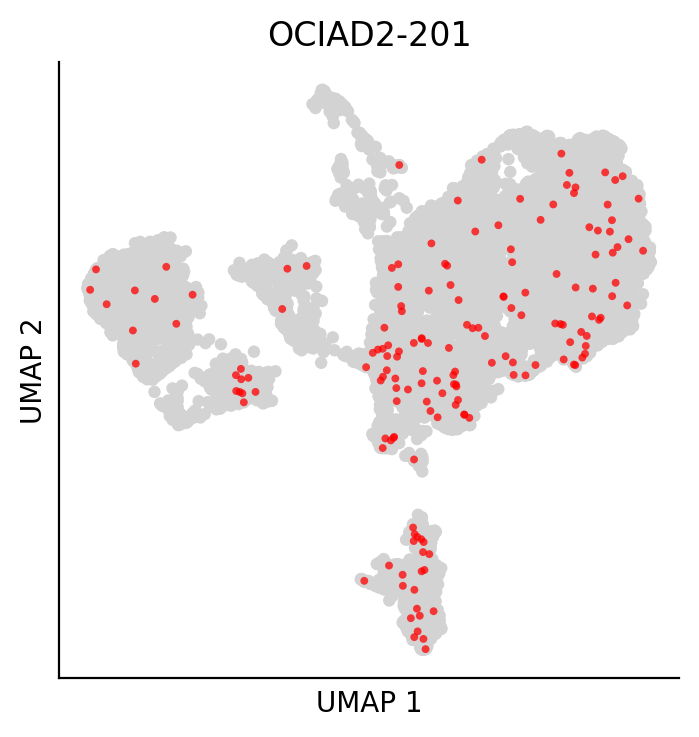

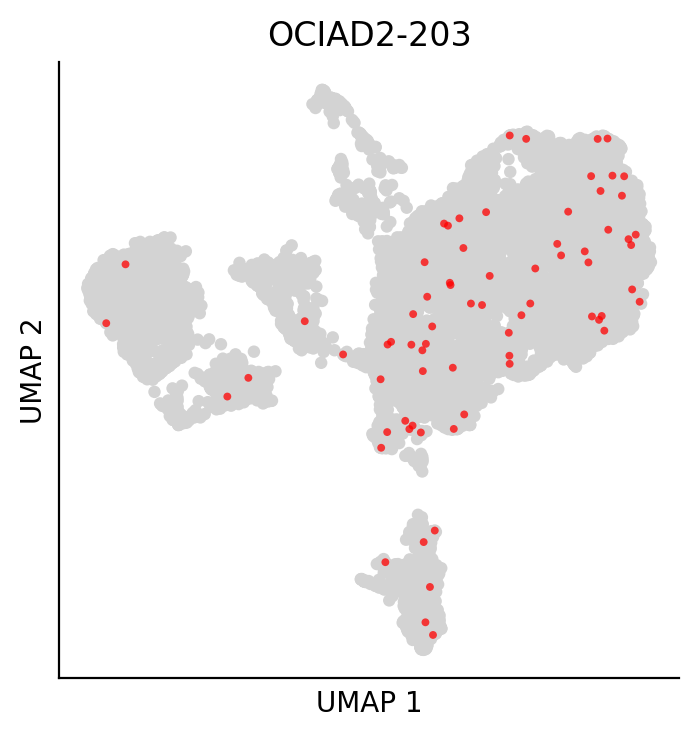

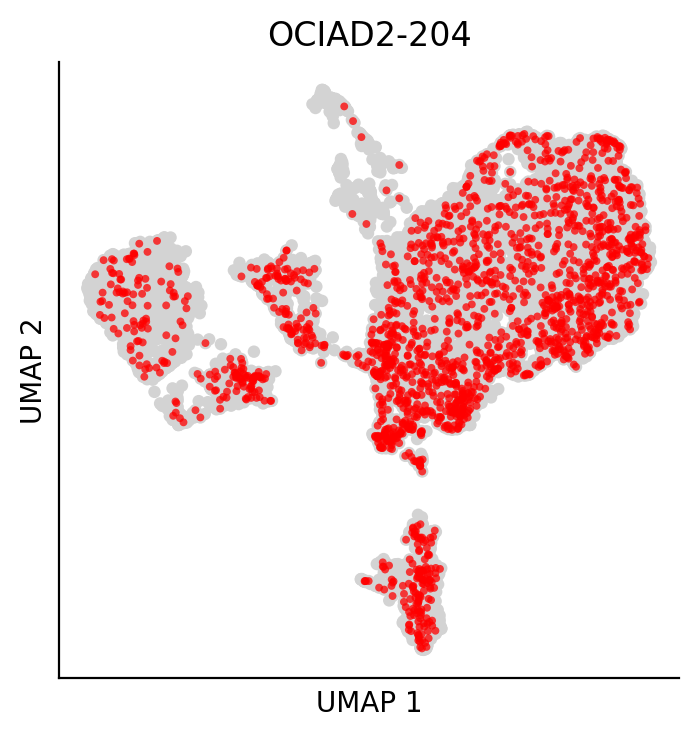

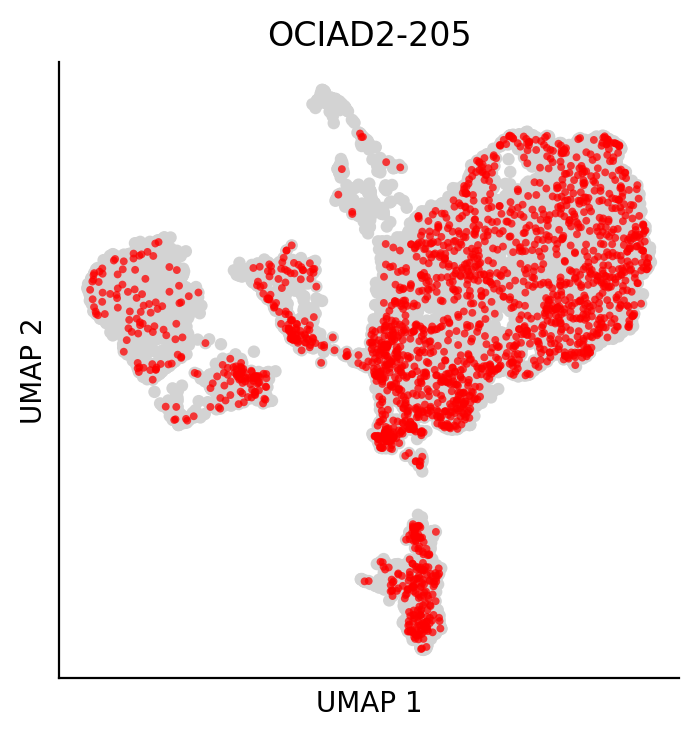

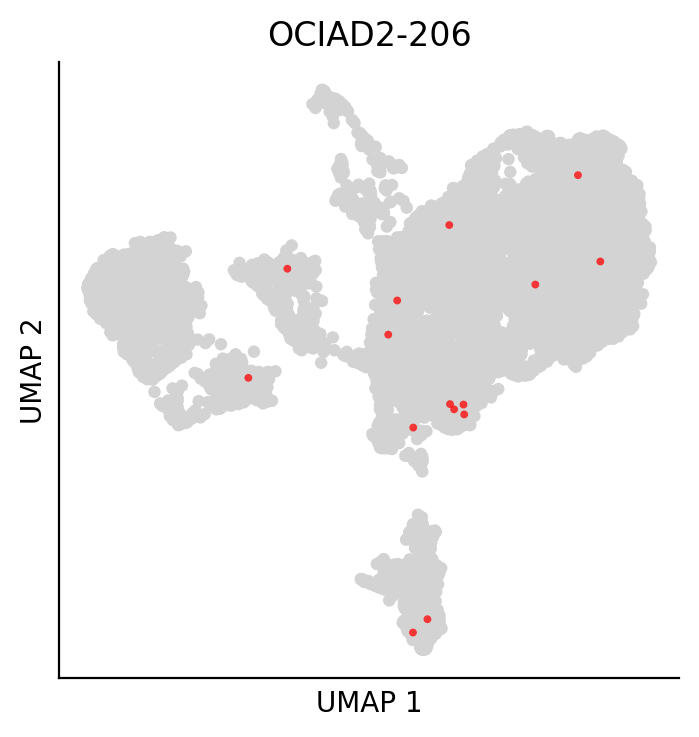

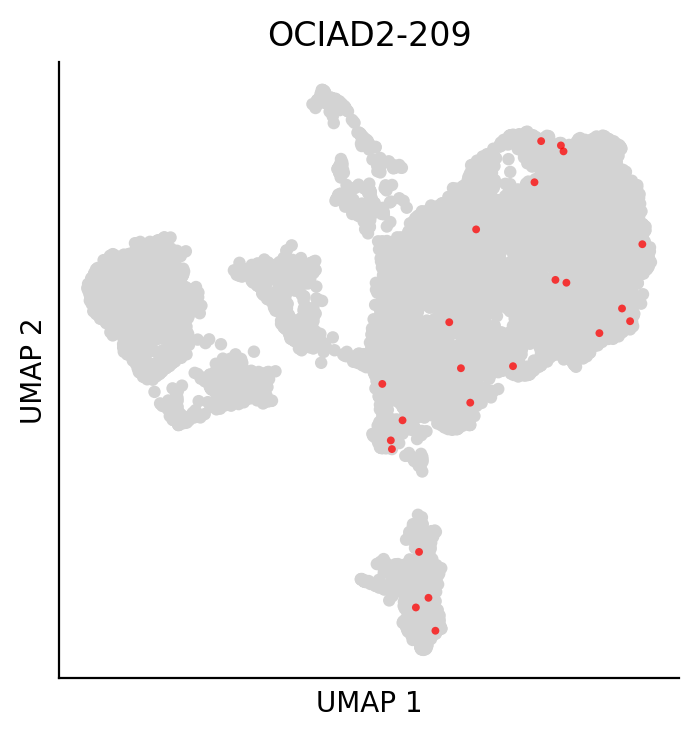

In [24]:
gene = 'OCIAD2'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

plot_umap_expression(pdf, gene)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

plot_dominant_isoform(pdf, gene)
plt.show()

plot_pivot(plot, gene)
plt.show()


query = list(pdf.var[pdf.var['gene_name'] == gene].index)
print(query)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_iso_single(pdf, query)

In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# HSC genes and TFS

In [ ]:
break

# find differential isoform usage

In [ ]:
pvals_adj = 0.05
logfoldchanges = 0.0

sig = deg.copy()
sig['gene_name'] = sig['names'].apply(lambda x: x.split("-")[0])

sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] >= logfoldchanges]
sig['n_deg'] = sig.groupby('gene_name')['group'].transform('nunique')
sig['n_iso'] = sig.groupby('gene_name')['names'].transform('nunique')

sig = sig[(sig['n_deg'] > 1) & (sig['n_iso'] > 1)]
print(f"{sig.shape=}")
print(f"{sig['gene_name'].nunique()=}")

all_genes = sig['gene_name'].unique()
all_genes

In [ ]:
tf_genes = adata.uns['scenic_transcription_factors']['gene_name'].to_list()
[x for x in all_genes if x in tf_genes]

In [ ]:
plot = deg.copy()
plot['gene_name'] = plot['names'].apply(lambda x: x.split("-")[0])

plot = pd.pivot_table(
    plot,
    index=['gene_name', 'names'],
    columns='group',
    values='pct_nz_group'
)

plot = plot.drop(columns='C6')

print(f"{plot.shape=}")

plot.head(15)

In [ ]:
rank_df = plot.rank(axis=1, ascending=False)
rank_df = (rank_df - 1).astype(int)

rank_df.head()

In [ ]:
query = 'CENPF'

plot = deg.copy()
plot['gene_name'] = plot['names'].apply(lambda x: x.split("-")[0])

plot = plot[plot['gene_name'] == query]
plot = plot.sort_values(by=['group', 'names'])

n_iso = plot['names'].nunique()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (1.1 * n_iso), 3

sns.barplot(
    data=plot,
    x='names',
    y='pct_nz_group',
    hue='group',
    palette='tab10',
    ec='k'
)

plt.xlabel("")
plt.ylabel("% Nonzero")
plt.gca().tick_params(axis='x', rotation=90)


# Get the positions of the x ticks
xticks = np.array(plt.gca().get_xticks())

# Calculate the positions for the vertical lines (midway between the ticks)
vlines_positions = (xticks[:-1] + xticks[1:]) / 2

# Add vertical dashed lines
for vline_pos in vlines_positions:
    plt.axvline(
        x=vline_pos, 
        color='gray', 
        linestyle='--', 
        linewidth=0.8,
    ) 

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper right',
    bbox_to_anchor=(1.2, 1),
)

plt.ylim([0,1])

sns.despine()

In [ ]:
gene = query

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

plt2.plot_umap_scatter(
    adata, 
    color=gene,
    title=gene,
    # vmin=0, 
    # vmax=10,
    colorbar=True,
    s=10,
)
plt.show()

query = list(pdf.var[pdf.var['gene_name'] == gene].index)
print(query)
plot_iso_single(pdf, query)

In [ ]:
break

# TSNE

In [ ]:
sc.tl.tsne(
    pdf,
)

sc.pl.tsne(
    pdf, 
    color=['cluster_str',],
)

In [ ]:
# sc.pp.neighbors(
#     pdf, 
#     n_neighbors=3,
#     use_rep='X',
#     n_pcs=None,
# )
# sc.tl.umap(pdf)
# sc.tl.tsne(
#     pdf,
#         use_rep='X',
# )
# sc.tl.leiden(
#     pdf, 
#     resolution=0.65, 
#     key_added='iso_cluster',
# )

# sc.pl.tsne(
#     pdf, 
#     color=['cluster_str', 'iso_cluster'],
# )

In [ ]:
break